Kollar de första raderna så jag ser att datan laddats korrekt:

In [1]:
import pandas as pd

df = pd.read_csv("housing.csv")
df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Skriver ut en lista med alla variabler (och funderar på vilken jag vill ha som Y och vilken/vilka att jämföra med)

Exempelvis:   
  
Y - Bunden variabel (Målvariabel/responsvariabel): median_house_value  
~  
X - Obunden variabel 1: ocean_proximity (dummy, INLAND som baseline)  
+  
X - Obunden variabel 2: persons_per_household  (population/households)

Vilket skulle ge: 
- geografisk faktor (läge)
- socioekonomisk faktor (trångboddhet)
- både kategorisk och kontinuerlig X
- tydlig tolkning
  
Om korrelationen mellan X och Y är för stark = problematiskt (kollinearitet)? 

In [12]:
print(list(df.columns))

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']


Kollar vilka typer av värden som finns i variablerna  
(numeriska: int, float och/eller kategoriska: object?)

Det gör jag för att identifiera kategoriska variabler (som jag inte vill ha med i min linjära regression). 

In [3]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

"ocean_proximity" = kategorisk variabel med dtype: object

statisktisk sammanställning för att få en överblick av variablernas olika värden: 

In [4]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Kollar efter saknade värden (bra att veta om någon variabel saknar data, pga olika mängd värden vid ex jämförelse)

In [5]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Kolumnen total_bedrooms har 207 rader med saknade värden. 

### Från kategoriska värden till numeriska.

Separerar numeriska och kategoriska kolumner (vid linjär regression måste datan vara numerisk, därför är det bra att se vilka variabler som har kategoriska värden som behöver korrigeras om om jag vill använda dessa som X (features) sedan): 

In [11]:
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = df.select_dtypes(include=["object"]).columns

print(f"numerical_cols: {list(numerical_cols)}, categorical_cols: {list(categorical_cols)}")




numerical_cols: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value'], categorical_cols: ['ocean_proximity']


Efter att ha jämfört de olika variablerna har jag valt att sätta min målvariabel (Y) till median_house_value med anlidningen att den är:  
- numerisk och kontinuerlig
- rimlig att jämföra andra variabler med(då den förmodligen påverkas av exempelvis läge och inkomst). 
  
Den gör:
- regressionskoefficienter tolkbara
- signifikans meningsfull
- resultat “realistiska”

### Oberoende variabel 1: 
**ocean_proximity (dummy, INLAND som baseline)**

Kollar vilka värden som finns i ocean_proximity för att sedan kunna göra om dem till numeriska värden: 

In [ ]:
df["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

Kollar också antalet värden per kategori för att få syn på vilka som är vanligast och om det finns väldigt få av några (viktigt vid tolkning sedan): 

In [14]:
df["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

För att ännu tydligare se propotionerna (hur vanligt förekommande i kategorin):

In [15]:
df["ocean_proximity"].value_counts(normalize=True)

ocean_proximity
<1H OCEAN     0.442636
INLAND        0.317393
NEAR OCEAN    0.128779
NEAR BAY      0.110950
ISLAND        0.000242
Name: proportion, dtype: float64

ISLAND - få av detta värde. Vid interpretation av regressionskoeffficienter måste man ha detta vid åtanke, då det kan leda till stora standardfel och "konstiga" koefficienter. 

Gör en scatterplot med hjälp av koordinaterna och hur de kategoriserats utifrån "ocean_proximity". på så sätt får jag en visuell överblig över datan: 

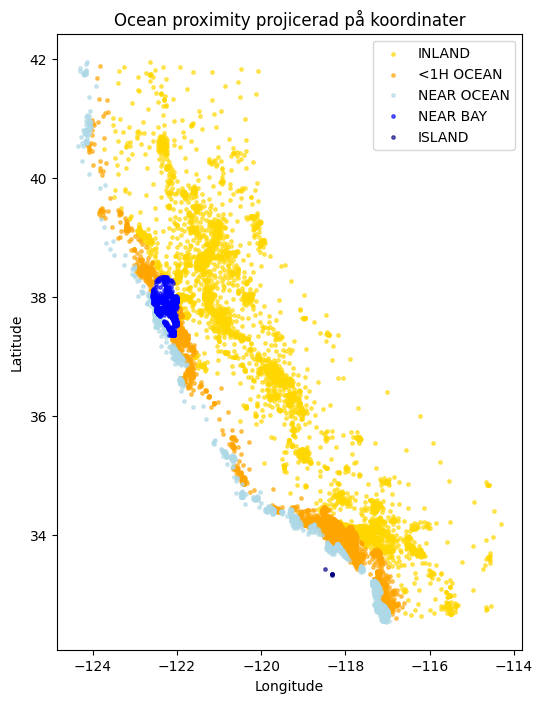

In [36]:
import matplotlib.pyplot as plt

color_map = {
    "INLAND": "gold",
    "<1H OCEAN": "orange",
    "NEAR OCEAN": "lightblue",
    "NEAR BAY": "blue",
    "ISLAND": "navy"
}

plt.figure(figsize=(6, 8))

for category, color in color_map.items():
    subset = df[df["ocean_proximity"] == category]
    plt.scatter(
        subset["longitude"],
        subset["latitude"],
        s=6,
        color=color,
        label=category,
        alpha=0.6
    )

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("Ocean proximity projicerad på koordinater")
plt.show()

Här syns det tydligt att INLAND till NEAR OCEAN (inklusive NEAR BAY och ISLAND) uppträder som en skala, där INLAND är längst från havet och NEAR OCEAN  uppträder som en skala, där INLAND är längst från havet och NEAR OCEAN(inklusive NEAR BAY och ISLAND) ligger närmast havet. Därmed bör vi också kunna sätta värdena när vi gör om dem från kategoriska till numeriska på ett sådant sätt att de inte bara ses som namn, utan som grader. Exempelvis högst poäng - närmast havet(Ordinalskala). Dock blir avståndet mellan dem oklara.. Så kanske bäst att hålla sig till en Nominalskala (där de olika värdena inte rangordnas, men har får olika värden)? 

Testar utifrån en skala bara för att se hur det ser ut: 

In [50]:
Index_ocean_proximity = {
    "INLAND": "1",
    "<1H OCEAN": "2",
    "NEAR OCEAN": "3",
    "NEAR BAY": "3",
    "ISLAND": "3"
}
df["Index_ocean_proximity"] = df["ocean_proximity"].map(Index_ocean_proximity).astype(int)

In [51]:
df[["median_house_value", "Index_ocean_proximity"]].corr()

,median_house_value,Index_ocean_proximity
median_house_value,1.000000,0.436212
Index_ocean_proximity,0.436212,1.000000


Ser ju ut som att det finns korrelation där.. 

Fråga: 
Nu syns det tydligt att det går som en skala - från INLAND till NEAR OCEAN (inklusive NEAR BAY och ISLAND). När jag kategoriserar dem - borde jag då klupa ihop NEAR OCEAN med NEAR BAY och ISLAND? För de behöver ju nödvändigtvis inte vara närmare havet än NEAR OCEAN egentligen? Eller är det bättre att ta bort NEAR BAY och ISLAND innan jag kollar om det finns någon korrelation med huspriser? Dock ser jag att NEAR BAY har ganska många värden i datan (nästan lika många som NEAR OCEAN), så då får vi ju mindre data att jämföra med... Hur borde jag tänka? 

Men då får vi ett "selektionsbias" och förlorar kanske information som är relevant vid regressionen. 

One-hot encoding av ocean_proximity (för att göra den numerisk). Börjar med att sätta en "baseline":  
  
- Baseline = alla dummy-variabler = 0
- Interceptet = förväntat Y för baseline
- Dummy-koefficient = skillnad mot baseline
- Baseline finns inte som kolumn eftersom den ligger i interceptet


Kopplat till **intercept β₀**: 
β₀ = förväntat värde på Y när alla X = 0

Om alla X = 0:  
Y = β₀  
    + β₁ · 0  
    + β₂ · 0  
    + β₃ · 0  
    + β₄ · 0  
Y = β₀  
  
om något X = 1, ex:  
Y = β₀  
    + β₁ · 1  
    + β₂ · 0  
    + β₃ · 0  
    + β₄ · 0  
Y = β₀ + β₁·1  
(vilket exempelvis kan ses som "hur mycket NEAR BAY skiljer sig(β₁) från INLAND (β₀)).  
  
**Tydliggörande:**  
  
- **baseline** är referenskategorin (INLAND), representeras av β₀ (har ingen dummy-variabel).   
- **Y**        är målvariabeln (baseline (β₀) + skillnad mot baseline (βᵢ)). 
- **X**        är variablerna (dummy-variabler + numeriska features). 
- **β**        är koefficienterna. 
- **β₀**       representerar baseline via interceptet. 
- **β₁…β₄**    är skillnaden i Y mellan X och baseline. 

Baseline - INLAND  
Väljer att ha INLAND som baseline då en stor andel av värdena i kategoring består av denna och att den ligger längst från havet. Det gör att jag kan sätta de numeriska värdena utifrån en startpunkt (längst från havet). Sedan kan jag jämföra skillnaden i kostnad beroende på detta.  
  
Koefficienterna kan alltså tolkas som "Hur mycket dyrare/billigare är huspriserna utifrån avstånd till havet?" 
  
Väljer ordningen på kategorierna så att de ligger i önskad ordning: 

In [27]:
df["ocean_proximity"] = pd.Categorical(
    df["ocean_proximity"],
    categories=[
        "INLAND",         # baseline
        "<1H OCEAN",
        "NEAR OCEAN",
        "NEAR BAY",
        "ISLAND"
    ]
)

Använder "dummies" som "hjälp-variabel" för att omvandla kategoriska värden till numeriska.  
  
"drop_first=True" för att första ketegorin (INLAND) tas bort (och används som baseline/referensnivå)

In [29]:
ocean_dummies = pd.get_dummies(
    df["ocean_proximity"],
    drop_first=True
)

In [31]:
ocean_dummies = ocean_dummies.astype(int)

In [32]:
ocean_dummies.head()

,<1H OCEAN,NEAR OCEAN,NEAR BAY,ISLAND
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


NEAR BAY jämförs mot INLAND (baseline). Därför är NEAR BAY = 1, och INLAND syns inte då denna är referensnivån. 

Dummy = 1 - om observationen tillhör kategorin
Dummy = 0 - annars 

### Oberoende variabel 2:
**persons_per_household  (population/households)**

Lägger till en ny variabel för att få en kvot mellan population och households, som kan tolkas som "antal personer per hushåll": 


In [40]:
df["persons_per_household"] = df["population"] / df["households"]
df.head()   

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,population_per_household,persons_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,2.555556,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,2.109842,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,2.802260,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,2.547945,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,2.181467,2.181467
